In [2]:
import pandas as pd
import numpy as np
import statsmodels.stats as st
import seaborn as ns
import matplotlib.pyplot as plt
import teradata 
udaExec = teradata.UdaExec ()

entain=r'C:/Users/apelle/.matplotlib/entain.mplstyle'
plt.style.use(entain)


In [3]:
#casino club are about 165 players and can't be unhosted,
#to identify casino club players search for condition: host_agent_team='VIP CasinoClub'

In [75]:
query='''
WITH CLV AS (
SEL TOP 850
scores.player_id,
scores.snapshot_date,
scores.model_score,
dc.Country_Desc
FROM dwprodviewsppmbi.Model_Daily_scores scores 
JOIN dim_player dp ON scores.player_id = dp.player_id
JOIN Dim_Player_Account dpa ON dpa.player_id = scores.player_id
JOIN Dim_Country dc ON dpa.country_Cd=dc.Country_CD
LEFT JOIN Dim_Player_Segmentation dps ON dp.player_id = dps.player_id														
LEFT JOIN Dim_Product dprod ON dps.Primary_Wh_Product_Cd = dprod.wh_product_cd	
WHERE 1 = 1
AND  scores.snapshot_date>=DATE-1
AND scores.player_id >0 
AND model_description_id IS IN (1,5,9)
AND dp.front_end_cd IN ('pp','pi','py','pe') 
AND dprod.Product_Desc = 'Casino'
AND dc.Country_Desc NOT IN ('united kingdom','Finland','Belarus','Russian Federation','Gibraltar','Sweden','Denmark','netherlands')
AND model_score >= 4000

ORDER BY model_score DESC
)

,
player

AS 
(SEL CASE WHEN clv. player_id IS NULL THEN dplh.player_id ELSE clv.player_id END  player_id,
CASE WHEN clv.player_id IS NULL THEN 'NOT IN clv' ELSE 'in_clv' END AS in_out,
CASE WHEN dplh.Host_Agent_First_Name='VIP NOT Hosted' THEN 'non hosted picked'
WHEN dplh.Host_Agent_First_Name IS NULL THEN 'CLV picked' 
ELSE 'Managed' END AS player_status

FROM clv
FULL OUTER JOIN (SEL * FROM DIM_PLAYER_HOST_LOG dplh 
WHERE host_agent_team IN ('PartyCasino VIP',
'Partycasino Vip team') AND host_end_date >= date-1
 AND host_agent_first_name <> 'VIP NOT Hosted' )  dplh ON clv.player_id=dplh.Player_Id
)





SEL 

fps.Player_Id,
CASE WHEN player_status='Managed' AND in_out='in_clv' THEN 'interesect'
WHEN player_status<>'Managed' THEN 'CLV_only'
ELSE 'Managed_only' END AS p_status,
SUM(fps.Bet_Amt_GBP) bet_amt,
SUM(fps.Bonus_Accrual_Cost_Amt_GBP) bonus_amt,
COUNT( DISTINCT CASE WHEN fps.bet_amt_gbp>0 THEN fps.Summary_Date END ) cpd

FROM FD_Player_Summary fps 
right outer JOIN player p ON fps.Player_Id=p.player_id
JOIN Dim_Skin ds ON fps.Wh_Skin_Id=ds.Wh_Skin_Id
WHERE fps.Summary_Date BETWEEN '2021-12-01' AND '2021-12-31'
AND ds.Wh_Product_Cd=2

GROUP BY 1,2'''

In [76]:
#Run query
with udaExec.connect("${dataSourceName}") as session:
    
    df=pd.read_sql_query(query,session)

session.close()

In [30]:
df.head()

,Player_Id,p_status,bet_amt,bonus_amt,cpd
0,18707372.0,CLV_only,31246.51064,417.02803,28.0
1,204442185.0,CLV_only,26297.98305,99.34753,12.0
2,551378148.0,Managed_only,8998.87795,0.00000,5.0
3,193821339.0,CLV_only,19276.77116,30.51060,10.0
4,534943794.0,interesect,51007.39565,108.35198,23.0


In [77]:
M=df[df['p_status']=='Managed_only'].Player_Id.count()
I=df[df['p_status']=='interesect'].Player_Id.count()
C=df[df['p_status']=='CLV_only'].Player_Id.count()

In [69]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

In [38]:
I

389

We can see how the number of CLV active players is higher than the number of Managed players, while we know the number of manaaged players is 997 not all of them are active

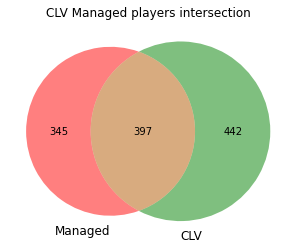

In [78]:
venn2(subsets = (M,C,I), set_labels = ('Managed', 'CLV'), alpha = 0.5);
plt.title('CLV Managed players intersection');

Reducing the number in the CLV group to match the number of active players from the Hosted group

In [90]:
C2=df[df['p_status']=='CLV_only'].sort_values('bet_amt').head(M).Player_Id.count()

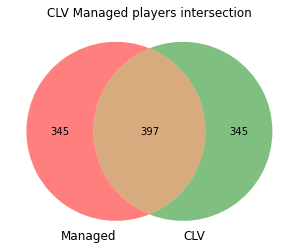

In [91]:
venn2(subsets = (M,C2,I), set_labels = ('Managed', 'CLV'), alpha = 0.5);
plt.title('CLV Managed players intersection');

 take away intersection to obtain rest of players, c stands for clean

In [129]:
df_M=df[df['p_status']=='Managed_only']
df_CLV=df[df['p_status']=='CLV_only'].sort_values('bet_amt',ascending=False).head(M)
df_c=df_M.append(df_CLV)

In [130]:
df_c.fillna(0,inplace=True)

In [131]:
len(df_c)

690

create theo NGR

In [132]:
df_c['t_ngr']=(df_c['bet_amt']*0.32)- df_c['bonus_amt']

In [133]:
df_c.describe()

,Player_Id,bet_amt,bonus_amt,cpd,t_ngr
count,6.900000e+02,6.900000e+02,690.000000,690.000000,690.000000
mean,4.458838e+08,7.524248e+04,356.027074,15.556522,23721.567931
std,1.760275e+08,1.643671e+05,814.302041,9.224368,52329.091148
min,8.921660e+05,0.000000e+00,0.000000,0.000000,-169.619356
25%,4.136632e+08,1.018432e+04,21.835115,8.000000,3144.798956
50%,5.347702e+08,3.103316e+04,137.250985,15.000000,9582.695999
75%,5.568228e+08,6.885320e+04,350.105457,23.000000,21003.821040
max,5.775991e+08,2.479206e+06,9573.974440,31.000000,792982.701712


Check variance for both Bet amt and Theo NGR

Variance coeffiecents for bet amt:
Managed = 290%
CLV = 171%



C:\Users\apelle\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 82.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\apelle\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 62.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Bet variance')

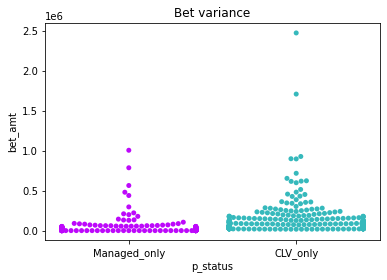

In [134]:

Y1=df_c[df_c['p_status']=='Managed_only']['bet_amt'].std()/df_c[df_c['p_status']=='Managed_only']['bet_amt'].mean()
Y2=df_c[df_c['p_status']!='Managed_only']['bet_amt'].std()/df_c[df_c['p_status']!='Managed_only']['bet_amt'].mean()
print('Variance coeffiecents for bet amt:'+'\n'+
     'Managed = ' +str( round(Y1*100) )+'%' +'\n'+
      'CLV = '+str( round(Y2*100) )+'%' +'\n' )
ns.swarmplot(y=df_c.bet_amt,x=df_c.p_status).set_title('Bet variance' )
#ns.swarmplot(y=Y2).set_title('Bet variance coefficent for CLV players= '+str(round(Y2.std()/Y2.mean() *100))+'%')


Variance coeffiecents for bet amt:
Managed = 296%
CLV = 77%



C:\Users\apelle\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 72.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\apelle\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 63.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'T_NGR variance')

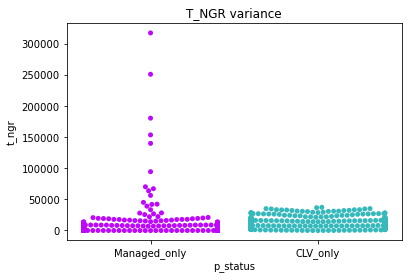

In [120]:

Y1=df_c[df_c['p_status']=='Managed_only']['t_ngr'].std()/df_c[df_c['p_status']=='Managed_only']['t_ngr'].mean()
Y2=df_c[df_c['p_status']!='Managed_only']['t_ngr'].std()/df_c[df_c['p_status']!='Managed_only']['t_ngr'].mean()
print('Variance coeffiecents for bet amt:'+'\n'+
     'Managed = ' +str( round(Y1*100) )+'%' +'\n'+
      'CLV = '+str( round(Y2*100) )+'%' +'\n' )
ns.swarmplot(y=df_c.t_ngr,x=df_c.p_status).set_title('T_NGR variance' )
#ns.swarmplot(y=Y2).set_title('Bet variance coefficent for CLV players= '+str(round(Y2.std()/Y2.mean() *100))+'%')


split the 2 groups into Managed (Vito) and CLV picked

In [135]:
vito=df_c[df_c['p_status']=='Managed_only']
CLV=df_c[df_c['p_status']!='Managed_only']

Altough this isn't going to be what we would normally do in reality we'll remove the outliers using a 3 zscore rule from the managed group and match the number of CLV only players to the final number of Managed players

In [256]:
from scipy import stats
A=vito[['t_ngr']]
A=A[(np.abs(stats.zscore(A)) < 3).all(axis=1)]
len(A)

               

339

Removing outliers from the managed players group leaves us with 339 players (we'll take 338 because we need an even split) 

In [257]:
A=A.head(338)

we now proceed to match the same amount of players in the CLV group 

In [163]:
B=CLV[['t_ngr']].sort_values('t_ngr',ascending=False).head(338)

In [267]:
def s_size(split_group, increase):
    ggr_gbp =split_group.values



    # define bootstrapping function
    def bootstrap_replicate_1d(data, func):
        """Generate bootstrap replicate of 1D data."""
     
        bs_sample = np.random.choice(data, len(data))
        return func(bs_sample)



    # create empty dict for the results
    test_results = {'sample size':[],'mean control':[],'std_control':[],'std_test':[],'mean test':[],'mean delta':[],
                    'delta LB':[],'delta UB':[],'P(T>C)':[]}




    # define how many itterations in bootstrapping
    samples = 10000


    bs_replicates_test = np.empty(samples)
    bs_replicates_control = np.empty(samples)

    # populate the array with mean values from the test group


    for n in range (13,int(len(ggr_gbp)/2),13):
        for i in range(samples):
            np.random.shuffle(ggr_gbp)

            a = ggr_gbp[:n]
            b = ggr_gbp[n:n*2]

            a=a*(increase)
            
            #print(np.random.choice(a))

            bs_replicates_test[i] = bootstrap_replicate_1d(np.array(a).flatten(),
                                                       np.mean)

            bs_replicates_control[i] = bootstrap_replicate_1d(np.array(b).flatten(),
                                                          np.mean)

    # calculate the mean of the test group
            mean_test = round(np.mean(bs_replicates_test),2)
            std_test=round(bootstrap_replicate_1d(np.array(a).flatten(),np.std),2)

    # calculate the mean of the control group
            mean_control = round(np.mean(bs_replicates_control),2)
            std_control=round(bootstrap_replicate_1d(np.array(b).flatten(),np.std),2)


    # calculate the difference in the means (test minus control)
            difference_in_mean = bs_replicates_test - bs_replicates_control
            mean_diff_in_mean = round(np.mean(difference_in_mean),2)

    # calculate the 95% confidence intervals in the difference of the means
            cfl_diff_in_mean = round(np.percentile(difference_in_mean,2.5),2)
            cfu_diff_in_mean = round(np.percentile(difference_in_mean,97.5),2)

    # calculate P(T>C)
            prob_test_higher_control = round(np.sum(bs_replicates_test>bs_replicates_control)/samples,2)

    # append the results to the dictionary
    #test_results['metric'].append(metric)
        test_results['sample size'].append(n)
        test_results['mean control'].append(mean_control)
        test_results['std_control'].append(std_control)
        test_results['mean test'].append(mean_test)
        test_results['std_test'].append(std_test)
        test_results['mean delta'].append(mean_diff_in_mean)
        test_results['delta LB'].append(cfl_diff_in_mean)
        test_results['delta UB'].append(cfu_diff_in_mean)
        test_results['P(T>C)'].append(prob_test_higher_control)

    # create the results dataframe from the results dictionary
    df_test_results = pd.DataFrame.from_dict(test_results)

    return df_test_results
    


In [329]:
def s_inc(split_group):
    ggr_gbp =split_group.values



    # define bootstrapping function
    def bootstrap_replicate_1d(data, func):
        """Generate bootstrap replicate of 1D data."""
     
        bs_sample = np.random.choice(data, len(data))
        return func(bs_sample)



    # create empty dict for the results
    test_results = {'increase':[],'mean control':[],'std_control':[],'std_test':[],'mean test':[],'mean delta':[],
                    'delta LB':[],'delta UB':[],'P(T>C)':[]}




    # define how many itterations in bootstrapping
    samples = 10000


    bs_replicates_test = np.empty(samples)
    bs_replicates_control = np.empty(samples)

    # populate the array with mean values from the test group

    import tqdm as tn
    for n in tn.tqdm_notebook(range (5,60,5)):
        for i in tn.tqdm_notebook(range(samples),leave=bool(n == 55)):
            np.random.shuffle(ggr_gbp)
                
            a = ggr_gbp[:int(len(ggr_gbp)/2)]
            b = ggr_gbp[int(len(ggr_gbp)/2)+1:]

            a=a*(1+(n/100))
            
            #print(np.random.choice(a))

            bs_replicates_test[i] = bootstrap_replicate_1d(np.array(a).flatten(),
                                                       np.mean)

            bs_replicates_control[i] = bootstrap_replicate_1d(np.array(b).flatten(),
                                                          np.mean)

    # calculate the mean of the test group
            mean_test = round(np.mean(bs_replicates_test),2)
            std_test=round(bootstrap_replicate_1d(np.array(a).flatten(),np.std),2)

    # calculate the mean of the control group
            mean_control = round(np.mean(bs_replicates_control),2)
            std_control=round(bootstrap_replicate_1d(np.array(b).flatten(),np.std),2)


    # calculate the difference in the means (test minus control)
            difference_in_mean = bs_replicates_test - bs_replicates_control
            mean_diff_in_mean = round(np.mean(difference_in_mean),2)

    # calculate the 95% confidence intervals in the difference of the means
            cfl_diff_in_mean = round(np.percentile(difference_in_mean,2.5),2)
            cfu_diff_in_mean = round(np.percentile(difference_in_mean,97.5),2)

    # calculate P(T>C)
            prob_test_higher_control = round(np.sum(bs_replicates_test>bs_replicates_control)/samples,2)

    # append the results to the dictionary
    #test_results['metric'].append(metric)
        test_results['increase'].append(n)
        test_results['mean control'].append(mean_control)
        test_results['std_control'].append(std_control)
        test_results['mean test'].append(mean_test)
        test_results['std_test'].append(std_test)
        test_results['mean delta'].append(mean_diff_in_mean)
        test_results['delta LB'].append(cfl_diff_in_mean)
        test_results['delta UB'].append(cfu_diff_in_mean)
        test_results['P(T>C)'].append(prob_test_higher_control)
        
        


    # create the results dataframe from the results dictionary
    df_test_results = pd.DataFrame.from_dict(test_results)
    
    #plotting
        
    fig=df_test_results[['increase','''P(T>C)''']].set_index('increase').plot()
    plt.ylabel('Probability Test > Control')
    IND=min(range(len(df_test_results['''P(T>C)'''])), key=lambda i: abs(df_test_results['''P(T>C)'''][i]-0.9))
    plt.axhline(0.9,color='darkblue',linestyle ="--")

    plt.axvline(df_test_results['increase'][IND],color='darkblue',linestyle ="--")
    plt.title('probability test vs control with sample size of: ' +str(int(len(ggr_gbp)/2) ) )
    

    return df_test_results
    


In [ ]:
test=s_inc(A)

C:\Users\apelle\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\apelle\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [4]:

def max_even(data):
    L=[]
    for i in reversed (range (len(data),0,1)
    if (i % 2) == 0:
        L.append(i)
print (max(L))
        

SyntaxError: invalid syntax (Temp/ipykernel_53692/812609019.py, line 4)